## Lecture 5. Introduction to Regression Analysis

![](./Data_and_Images/Chapter_5/1.Predictive_Modeling.png)
![](./Data_and_Images/Chapter_5/2.Data_Terminology.png)
![](./Data_and_Images/Chapter_5/3.Terminology_Example.png)

In [ ]:
# -*- coding: UTF-8 -*-
%autosave 120
%load_ext version_information
%version_information pandas, numpy, matplotlib, seaborn, tensorflow, scipy

作者為本章撰寫了以下的三個自定義函數，主要是執行肩並肩的列印、釋放記憶體空間以及建立工作區目錄。請讀者自行了解其Python代碼的寫法

In [1]:
# 定義函數以便執行肩並肩的列印
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

In [2]:
# 釋放記憶體空間 - Free Memory
# (1) 獲取物件及其大小的排序列表 
# (2) 將刪除的物件所佔的記憶體釋放
def memoryClean(dirList):
    print('Total Process Memory Usages: %s' %psutil.Process().memory_info().rss)
    print('Memory Usage Statistics: %s' %str(psutil.virtual_memory()))
    reserved_vars = ['In', 'Out', 'exit', 'quit', 'ipython_vars', 
                     'side_by_side', 'memoryClean']
    # Display Memory Usage
    # sorted([(x, sys.getsizeof(globals().get(x))) for x in dir()
            # if not x.startswith('_') and
            # x not in sys.modules and
            # x not in ipython_vars],key=lambda x: x[1], reverse=True)
    for name in dirList:
        if not name.startswith('_') and name not in sys.modules and name not in reserved_vars:
            del globals()[name]
    import gc
    gc.collect()

In [3]:
# 建立目錄
IODataDir = "./Data_and_Images"
import os
if not os.path.exists(IODataDir):
    os.makedirs(IODataDir)

## 本章目錄

* [1. Linear Regression](#1.-Linear-Regression)
    * [1.1 Linear Systems](#1.1-Linear-Systems)
    * [1.2 Normal Equation and Least Squares Method](#1.2-Normal-Equation-and-Least-Squares-Method)
    * [1.3 Gradient Decent Optimization Algorithm](#1.3-Gradient-Decent-Optimization-Algorithm)
        * [1.1.1 Gradient Descent Concept and Mathematics](#1.1.1-Gradient-Descent-Concept-and-Mathematics)
        * [1.1.1 Batch Gradient Descent](#1.1.1-Batch-Gradient-Descent)
        * [1.1.2 Compute The Gradient](#1.1.2-Compute-The-Gradient)
    * [1.4 Gradient Descent Variants](#1.4-Gradient-Descent-Variants)
        * [1.4.1 The Batch Gradient Descent Example](#1.4.1-The-Batch-Gradient-Descent-Example)
        * [1.4.2 The Stochastic Gradient Descent(SGD) Example](#1.4.2-The-Stochastic-Gradient-Descent&#40;SGD&#41;-Example)
        * [1.4.3 SGD with Simulated Annealing and Scikit-Learn Example](#1.4.3-SGD-with-Simulated-Annealing-and-Scikit-Learn-Example)
        * [1.4.4 The Mini-batch Gradient Descent with Simulated Annealing Example](#1.4.4-The-Mini-batch-Gradient-Descent-with-Simulated-Annealing-Example)
        * [1.4.5 Learning Processes of Gradient Descent Variants](#1.4.5-Learning-Processes-of-Gradient-Descent-Variants)
    * [1.5 Linear Regression with TensorFlow](#1.5-Linear-Regression-with-TensorFlow)
        * [1.5.1 Using the Normal Equation](#1.5.1-Using-the-Normal-Equation)
        * [1.5.2 Using Batch Gradient Descent](#1.5.2-Using-Batch-Gradient-Descent)
        * [1.5.3 Using Mini-Batch Gradient Descent](#1.5.3-Using-Mini-Batch-Gradient-Descent)
* [2. Types of Regression](#2.-Types-of-Regression)
    * [2.1 Polynomial Regression](#2.1-Polynomial-Regression)
    * [2.2 High-degree Polynomial Regression](#2.2-High-degree-Polynomial-Regression)
    * [2.3 Learning Curve](#2.3-Learning-Curve)
    * [2.4 Model Complexity Generalization Error - The Bias-Variance Tradeoff](#2.4-Model-Complexity-Generalization-Error---The-Bias-Variance-Tradeoff)
    * [2.5 Regularized Linear Model - Ridge Regression](#2.5-Regularized-Linear-Model---Ridge-Regression)

[回本章目錄](#本章目錄)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import matplotlib.mlab as mlab
%matplotlib inline

[回本章目錄](#本章目錄)

# <font color='red'>1. Linear Regression</font>

# <font color='red'>1.1 Linear Systems</font>
### Consider the following set of equations:
### $$\begin{array}{r}w_{1} & + & 5 \, w_{2} & - & 5.3 \, w_{3} & = & y_{1} \\2.4 \, w_{1} & - & 2 \, w_{2} & + & w_{3} & = & y_{2} \\7.8 \ w_{1} & - & 4.1 \, w_{2} & + & 6.4 \, w_{3} & = & y_{3} \\\end{array}$$
> ### Notice that $y_{i}$, $i = 1, 2, 3$, are linear combinations of vector $w_{i}$ of the variables $w_{1}$, $w_{2}$, $w_{3}$
> ### This set of equations can be written in matrix notation as follows:
> ### $\mathbf{w}\, \mathbf{X} = \mathbf{y},\quad where\quad \mathbf{X} = \left[\begin{array}{ccc}1 & 5 & -5,3 \\2,4 & -2 & 1 \\7,8 & -4,1 & 6,4\end{array}\right], \quad\mathbf{y} = \left[\begin{array}{c}y_{1} \\y_{2} \\y_{3}\end{array}\right],\quad \mathbf{w} = \left[\begin{array}{c}w_{1} \\w_{2} \\w_{3}\end{array}\right]$
> ### The above is commonly called linear system of equations or <Font color='red'>simply linear system</Font>
> ### Therefore, solving a linear system means determining the vector $\mathbf{w}$ from the values of $\mathbf{X}$ and $\mathbf{y}$. The complexity of the algorithm used for solving a linear system depends mainly on the structure of the matrix $\mathbf{X}$:
>> ### If $\mathbf{X}$ is a square matrix and is non-singular, we can solve$\mathbf{w}$ easily.
>> ### $$\mathbf{w}=(\mathbf{X})^{-1}\mathbf{y}$$ 

> ### The [numpy.linalg](http://docs.scipy.org/doc/numpy/reference/routines.linalg.html) provides a lot of linear algebra routines. The cells below show an application of the routine [numpy.linalg.solve](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html#numpy.linalg.solve) for solving a linear system.

### Example - Solve the system of equations 3 * x0 + x1 = 9 and x0 + 2 * x1 = 8:

In [5]:
a = np.array([[3,1], [1,2]])
b = np.array([9,8])
# 解聯立方程式
x = np.linalg.solve(a, b)
x

array([2., 3.])

### Check that the solution is correct:

In [6]:
np.allclose(np.dot(a, x), b)

True

### Matrix Division
> ### To divide in a matrix algebra world we first need to invert the matrix.  It is useful to consider the analog case in a scalar work.  Suppose we want to divide the $f$ by $g$.  We first invert g and then we multiply f times g: $$\frac{f}{g}=f \times g^{-1}$$
> ### Inverting a Matrix: Consider the square $2\times 2$ matrix $A=\bigl( \begin{smallmatrix} a_{11} & a_{12} \\ a_{21} & a_{22}\end{smallmatrix} \bigr)$.  Let the inverse of matrix A (denoted as $A^{-1}$) be 
### $$A^{-1}=\begin{bmatrix}a_{11} & a_{12} \\a_{21} & a_{22}\end{bmatrix}^{-1}=\frac{1}{a_{11}a_{22}-a_{12}a_{21}}	\begin{bmatrix} a_{22} & -a_{12} \\ -a_{21} & a_{11}\end{bmatrix}$$
### The inverted matrix $A^{-1}$ has a useful property:
$$\begin{equation}A \times A^{-1}=A^{-1} \times A=I\end{equation}$$
### where I, the identity matrix (the matrix equivalent of the scalar value 1), is
$$I_{2 \times 2}=\begin{bmatrix}1 & 0 \\0 & 1\end{bmatrix}$$
### furthermore, $A \times I = A$ and $I \times A = A$.

In [7]:
C = np.arange(4).reshape((2,2))
# 原來矩陣, 反矩陣, 單位矩陣(矩陣乘以反矩陣)
side_by_side(C, np.linalg.inv(C), C.dot(np.linalg.inv(C)))

array([[0, 1],     array([[-1.5,  0.5],     array([[1., 0.], 
       [2, 3]])           [ 1. ,  0. ]])           [0., 1.]])



### An important feature about matrix inversion is that <font color='red'>it is undefined if (in the $2 \times 2$ case), $a_{11}a_{22}-a_{12}a_{21}=0$</font>.  If this relationship is equal to zero the inverse of A does not exist (<font color='red'>a.k.a. singular matrix</font>).  If this term is very close to zero, an inverse may exist but $A^{-1}$ may be poorly conditioned meaning that it is prone to rounding error and is likely not well identified computationally.  The term $a_{11}a_{22}-a_{12}a_{21}$ is the determinant of matrix A, and for square matrices of size greater than $2 \times 2$, if equal to zero indicates that you have a problem with your data matrix (columns are linearly dependent on other columns).  The inverse of matrix A exists if A is square and is of full rank (ie. the columns of A are not linear combinations of other columns of A).

### Checking whether X matrix is singular or not ( Linear dependence of vectors)

In [8]:
aMatrix =  np.matrix("1,-1,0;0,-2,1;2,4,-3").T
# 計算行列式，行列式值等於零者沒有反矩陣
if np.linalg.det(aMatrix) != 0:
    print(np.linalg.inv(aMatrix))
else:
    print("It is a singular matrix. The determinant of the matrix is ", np.linalg.det(aMatrix))

It is a singular matrix. The determinant of the matrix is  0.0


[回本章目錄](#本章目錄)

## <font color='red'>1.2 Normal Equation and Least Squares Method</font>

### Let's consider a set of measurements $d_{i}$, $i = 1, \dots, N$, of a given physical quantity. **The measurements** $d_{i}$ **are usually called observed(desired) data**. Let's also consider that each observed data $d_{i}$ can be properly approximated by a function $y_{i}$, $i = 1, \dots, N$, given by:
### $$ y_{i} = x_{i1} \, w_{1} + x_{i2} \, w_{2} + \cdots + x_{iM} \, w_{M} \: , $$
### where $x_{ij}$ are known variables and $w_{j}$ are unknown variables, $i = 1, \dots, N$, $j = 1, \dots, M$, $N \gt M$. **The** $y_{i}$ **are usually called predicted data**. Notice that M and N are not equal (e.g. if M > N, the system is *underdetermined* and has an infinite number of solutions).
### Then, by considering the $N$ measurements, we obtain
$$\begin{split}d_{1} &\approx \; &y_{1} &= \: &x_{11} \, w_{1} + &x_{12} \, w_{2} + \cdots + &x_{1M} \, w_{M} \\d_{2} &\approx &y_{2} &= &x_{21} \, w_{1} + &x_{22} \, w_{2} + \cdots + &x_{2M} \, w_{M} \\\vdots & &\vdots & & \: \vdots & \: \vdots & \: \vdots \\d_{N} &\approx &y_{N} &= &x_{N1} \, w_{1} + &x_{N2} \, w_{2} + \cdots + &x_{NM} \, w_{M}\end{split}$$
### or, equivalently,$$\mathbf{d} \approx \mathbf{y} = \mathbf{X} \, \mathbf{w} \: ,$$where$$\mathbf{w} = \left[\begin{array}{c}w_{1} \\w_{2} \\\vdots \\w_{M}\end{array} \right] \: ,$$ $$\mathbf{y} = \left[ \begin{array}{c}y_{1} \\y_{2} \\\vdots \\
y_{N}\end{array} \right] \: ,$$ $$\mathbf{d} = \left[ \begin{array}{c}d_{1} \\d_{2} \\
\vdots \\d_{N}\end{array} \right]$$ and$$\mathbf{X} =\left[ \begin{array}{cccc}x_{11} & x_{12} & \cdots & x_{1M} \\x_{21} & x_{22} & \cdots & x_{2M} \\\vdots & \vdots & & \vdots \\x_{N1} & x_{N2} & \cdots & x_{NM}
\end{array} \right] \: .$$
### The vectors $\mathbf{w}$, $\mathbf{y}$, and $\mathbf{d}$ are usually called **parameter vector**, **predicted data vector**, and **observed(desired) data vector**, respectively. Notice that determining the parameter vector $\mathbf{w}$ from $\mathbf{d}$ and $\mathbf{X}$ requires to solve a non-square linear system ($\mathbf{M} \neq \mathbf{N}$).

### <font color='red'>Approximate Solution of $X^{-1}$ Using Least Square Medthod(LSM)最小平方法</font>
### Let the error function be $ J(w) = \frac{1}{2} (w^{*}X-y)^{T} (w^{*}X-y)$, we want to find a $w^{*}$ such that $J(w)$ is the minimum.
### We first let $$\frac{\partial J(w)}{\partial w} = 0$$
### $$ X^{T}Xw=X^{T}y $$
### $$ w^{*}=w=(X^{T}X)^{-1}X^{T}y $$ 
### where $(X^{T}X)^{-1}X^{T}$ is called a pseudo inverse matrix, denoted as $X^{+}$ 近似的反矩陣

### <font color='red'>Example - Compute *w* Using the Normal Equation</font>
### <font color='red'>Generate sample data and add noise to data

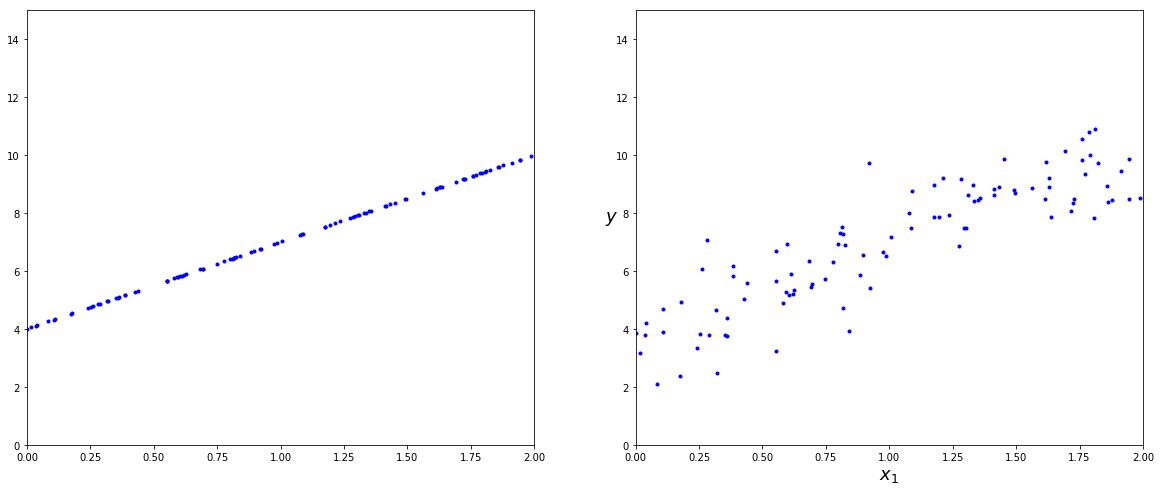

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X
yNoise = 4 + 3 * X + np.random.randn(100, 1)
# ax1為沒noise的圖
ax1.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
# ax2為有noise的圖
ax2.plot(X, yNoise, "b.")
ax1.axis([0, 2, 0, 15])
ax2.axis([0, 2, 0, 15])
plt.show()

### <font color='red'>Find w</font>

In [10]:
MatX = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
# 近似反矩陣
weightBest = np.linalg.inv(MatX.T.dot(MatX)).dot(MatX.T).dot(yNoise)
side_by_side(MatX[0:9], weightBest)

array([[1.        , 1.63029277],     array([[3.65525379], 
       [1.        , 1.85828693],            [3.27666067]])
       [1.        , 0.98647857],                          
       [1.        , 0.97466708],                          
       [1.        , 1.61608329],                          
       [1.        , 1.41434218],                          
       [1.        , 1.69209915],                          
       [1.        , 1.41117914],                          
       [1.        , 1.4513526 ]])                         



### <font color='red'>Model prediction</font>

array([[0],     array([[ 4],     array([[ 3.65525379], 
       [2]])           [10]])           [10.20857514]])



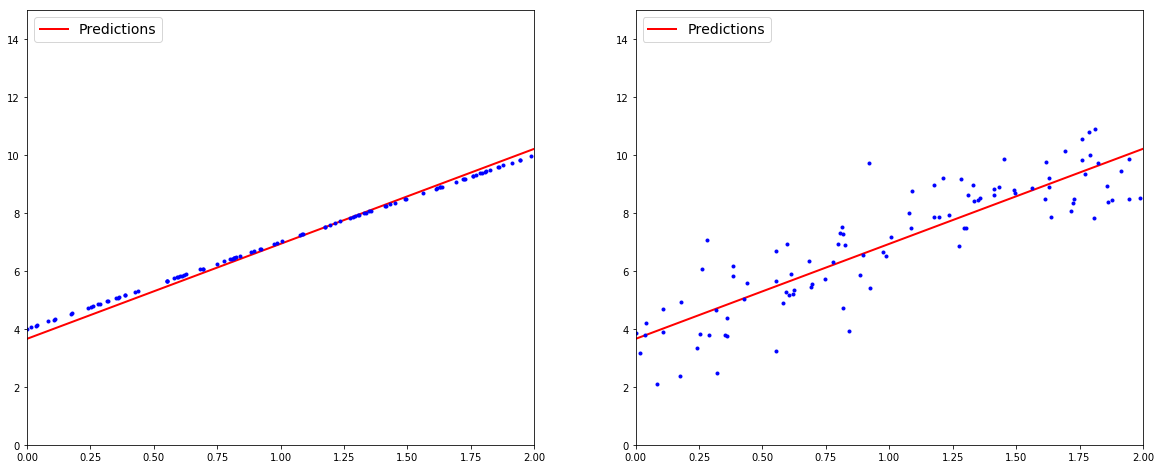

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
XNew = np.array([[0], [2]])
MatXNew = np.c_[np.ones((2, 1)), XNew]  # add x0 = 1 to each instance
yPredict = MatXNew.dot(weightBest);
side_by_side(XNew, 4 + 3 * XNew, yPredict)
ax1.plot(XNew, yPredict, "r-", linewidth=2, label="Predictions")
ax1.plot(X, y, "b.")
ax1.legend(loc="upper left", fontsize=14)
ax2.plot(XNew, yPredict, "r-", linewidth=2, label="Predictions")
ax2.plot(X, yNoise, "b.")
ax2.legend(loc="upper left", fontsize=14)
ax1.axis([0, 2, 0, 15])
ax2.axis([0, 2, 0, 15])
plt.show()

### <font color='red'>Linear Regression with Scikit-Learn</font>

In [12]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linRegNoise = LinearRegression()
linReg.fit(X, y)
linRegNoise.fit(X, yNoise)
side_by_side("No noise added data ==>","w0 = {0:.2f}".format(linReg.intercept_[0]),
             "w coefficient(s) = "+str(linReg.coef_[0]))
side_by_side("  Noise added data  ==>","w0 = {0:.2f}".format(linRegNoise.intercept_[0]), 
             "w coefficient(s) = "+str(linRegNoise.coef_[0]))
side_by_side("Prediction Results  ==>", "New Data = "+''.join(map(str,XNew)), 
             "No noise = "+''.join(map(str,linReg.predict(XNew))), 
             "Noise added = "+''.join(map(str,linRegNoise.predict(XNew))))

'No noise added data ==>'    'w0 = 4.00'    'w coefficient(s) = [3.]'

'  Noise added data  ==>'    'w0 = 3.66'    'w coefficient(s) = [3.27666067]'

'Prediction Results  ==>'    'New Data = [0][2]'    'No noise = [4.][10.]'    'Noise added = [3.65525379][10.20857514]'



[回本章目錄](#本章目錄)

## <font color='red'>1.3 Gradient Decent Optimization Algorithm</font>

### <font color='red'>Computational Complexity of The Normal Equation - Features and Instances</font>

> ### <font color='red'>Number of Features</font>: The Normal Equation computes the inverse of $X^{T}$ · $X$, which is an $n \ × m$ matrix (where m is the number of features). The computational complexity of inverting such a matrix is typically about *O($m^{2.4}$)* to *O($m^{3}$)* (depending on the implementation). In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4}$ = 5.3 to $2^{3}$ = 8. The Normal Equation gets very slow when the number of features grows large (e.g., 100,000).
> ### <font color='red'>Number of Instances</font>: On the positive side, this equation is linear with regards to the number of instances in the training set (it is O(n)), so it handles large training sets efficiently, provided they can *fit in memory*. Also, once we have trained our Linear Regression model, predictions are very fast: the computational complexity is linear. In other words, making predictions on twice as many instances (or twice as many features) will just take roughly twice as much time.

### <font color='red'>Error Surface - Finding the Minimum Error</font>

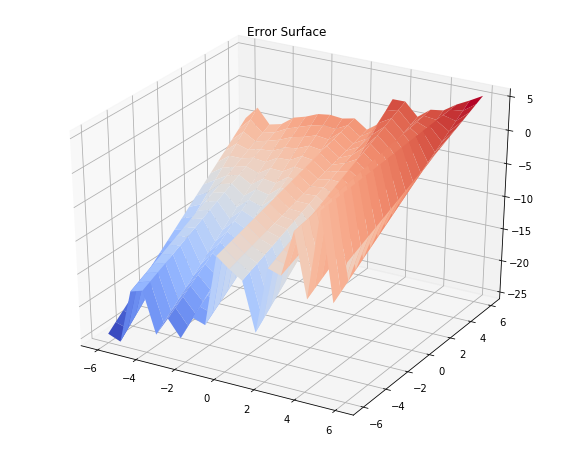

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
size = 20
x1 = list(np.linspace(-6, 6, size))
x2 = list(np.linspace(-6, 6, size))
x1, x2 = np.meshgrid(x1, x2)
error = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        x = np.matrix([[x1[i,j]], [x2[i,j]]])
        error[i,j] = float(MatX[j].dot(x) - yNoise[j])
ax.plot_surface(x1, x2, error, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
plt.title('Error Surface')
plt.show()

[回本章目錄](#本章目錄)

## <font color='red'>1.3.1 Gradient Descent Concept and Mathematics</font>

![](./Data_and_Images/Chapter_5/GD_concept.png)
![](./Data_and_Images/Chapter_5/GD_math.png)

### <font color='red'>1.3.2 Compute The Gradient</font>

> ### Let $X^{i}$ denote the $i^{th} $ input vector, $Y^{i}$ denote the $i^{th}$ target variable, $m$ is the number of features.
> ### A pair $(X^{(i)}$, $Y^{(i)})$ is called a training example.
> ### A list of n training examples {$(X^{(i)}, Y^{(i)}); i = 1, \cdots ,n$} is called a training set.
> ### We have $ \hat{Y}^{(i)} = W_{0}+W_{1}X^{(i)}_{1}+W_{2}X^{(i)}_{2}+\cdots+W_{m}X^{(i)}_{m}$ for the input vector $i$.
> ### Let the error function be $ J(W) = \frac{1}{2}(\hat{Y}^{(i)}-Y^{(i)})^{2}$
> ### $$ \frac{\partial J(W)}{\partial W_{j}} = 2\cdot\dfrac{1}{2}(\hat{Y}^{(i)}-Y^{(i)})\frac{\partial}{\partial W_{j}}(W_{0}+W_{1}X^{(i)}_{1}+W_{2}X^{(i)}_{2}+\cdots+W_{m}X^{(i)}_{m}-Y)\\=(\hat{Y}^{(i)}-Y^{(i)})X^{(i)}_{j}$$

![](./Data_and_Images/Chapter_5/GD_summing.png)
![](./Data_and_Images/Chapter_5/GD_figure.png)

[回本章目錄](#本章目錄)

## <font color='red'>1.4 Gradient Descent Variants</font>

> ### <font color='red'>Batch Gradient Descent</font>
> ### $$W_{j} := W_{j}-\eta\sum_{i=1}^{n}(\hat{Y}^{(i)}-Y^{(i)})X^{(i)}_{j},\quad\text{for every $j$}$$
> ### <font color='red'>Stochastic Gradient Descent</font>
> ### $$\text{for $i$ = 1 to $n$:}\quad\quad W_{j} := W_{j}-\eta(\hat{Y}^{(i)}-Y^{(i)})X^{(i)}_{j},\quad\text{for every $j$}$$

![](./Data_and_Images/Chapter_5/GD_variants.png)

[回本章目錄](#本章目錄)

### <font color='red'>1.4.1 The Stocastic Gradient Descent Example</font>
### Calculations over the full training set X, at each Gradient Descent step
### Selection of MSE (Mean Square Error) Cost Function

### <font color='red'>Weight changed for every single input sequentially</font>

In [14]:
learningRate = 0.1 # eta
noIterations = 1000
N = 100 
weights = np.random.randn(2,1) # theta
for iteration in range(noIterations):
    gradients = 2/N * MatX.T.dot(yNoise - MatX.dot(weights))
    weights = weights + learningRate * gradients
print(weights)

[[3.65525379]
 [3.27666067]]


### <font color='red'>Recording weight changed path with different learning rate</font>

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in add


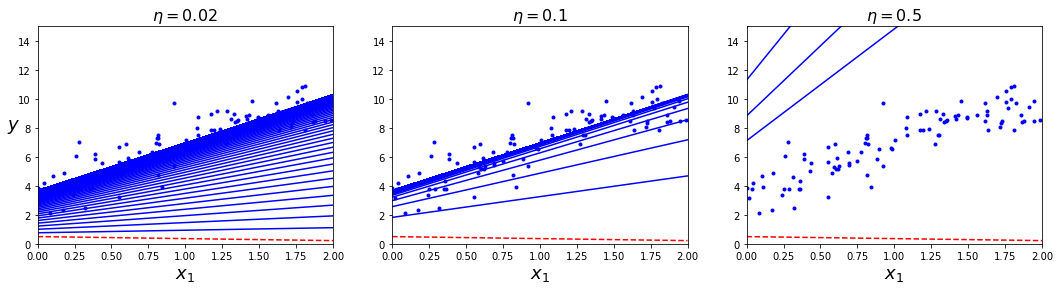

In [15]:
weightPathBGD = []
def plotGradientDescent(weights, learningRate, weightPath=None):
    N = len(MatX)
    plt.plot(X, yNoise, "b.")
    noIterations = 10000
    for iteration in range(noIterations):
        if iteration < 1000:
            yPredict = MatXNew.dot(weights)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(XNew, yPredict, style)
        gradients = 2/N * MatX.T.dot(yNoise - MatX.dot(weights))
        weights = weights + learningRate * gradients
        if weightPath is not None:
            weightPath.append(weights)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(learningRate), fontsize=16)

np.random.seed(42)
weights = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(18,4))
# 學習綠的差異
plt.subplot(131); plotGradientDescent(weights, learningRate = 0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plotGradientDescent(weights, learningRate = 0.1, weightPath=weightPathBGD)
plt.subplot(133); plotGradientDescent(weights, learningRate = 0.5)
plt.show()

[回本章目錄](#本章目錄)

### <font color='red'>1.4.2 The Stochastic Gradient Descent(SGD) Example</font>

> ### <font color='red'>Batch Gradient Descent</font> uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. 
> ### <font color='red'>Stochastic Gradient Descent</font> picks an instance randomly in the training set and computes the gradients at every step. This makes the algorithm much faster since it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets. (e.g. online learning). As its stochastic nature, this algorithm is much less regular, the value of cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum. When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent does.
> ### <font color='red'>SGD with Simulated Annealing</font>: Randomness is somehow good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate. The learning rates start out large, then get smaller and smaller, allowing the algorithm to settle at the global minimum. This process is called simulated annealing.

[回本章目錄](#本章目錄)

### <font color='red'>1.4.3 SGD with Simulated Annealing and Scikit-Learn Example</font>

weights: [[3.64788713]
 [3.28898472]]


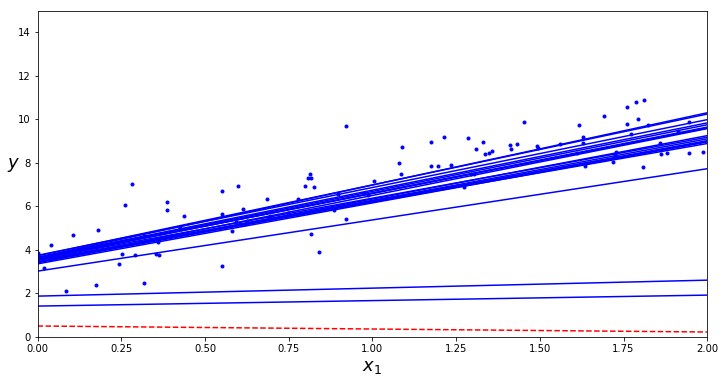

In [16]:
weightPathSGD = []
N = len(MatX)
np.random.seed(42)
# 幾個epoch
noEpochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters
def learningSchedule(t):
    return t0 / (t + t1)

weights = np.random.randn(2,1)  # random initialization
plt.figure(figsize=(12,6))
for epoch in range(noEpochs):
    for i in range(N):
        if epoch == 0 and i < 20:                    
            yPredict = MatXNew.dot(weights)          
            style = "b-" if i > 0 else "r--" 
            plt.plot(XNew, yPredict, style)     
        ranNDX = np.random.randint(N)
        xi = MatX[ranNDX:ranNDX+1]
        yi = yNoise[ranNDX:ranNDX+1]
        # gradients = 2/N * MatX.T.dot(yNoise - MatX.dot(weights))
        gradients = 2 * xi.T.dot(yi - xi.dot(weights))
        learningRate = learningSchedule(epoch * N + i)
        weights = weights + learningRate * gradients
        weightPathSGD.append(weights)
plt.plot(X, yNoise, "b.")                                
plt.xlabel("$x_1$", fontsize=18)                    
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
print('weights: %s' %weights)
plt.show()                                          

### <font color='red'>SGD with Scikit-Learn Example</font>

In [17]:
from sklearn.linear_model import SGDRegressor
regSGD = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, random_state=42)
regSGD.fit(X, yNoise.ravel());
side_by_side("  Initial weights   ==>","w0 = {0:.2f}".format(weights[0][0]), 
             "w coefficient(s) = {0:.2f}".format(weights[1][0]))
side_by_side("  Noise added data  ==>","w0 = {0:.2f}".format(regSGD.intercept_[0]), 
             "w coefficient(s) = "+str(regSGD.coef_[0]))

'  Initial weights   ==>'    'w0 = 3.65'    'w coefficient(s) = 3.29'

'  Noise added data  ==>'    'w0 = 3.61'    'w coefficient(s) = 3.2208626993488547'



[回本章目錄](#本章目錄)

### <font color='red'>1.4.4 The Mini-batch Gradient Descent with Simulated Annealing Example</font>
> ### Instead of computing the gradients based on the full training set (as in BGD) or based on just one instance (as in SGD), Mini-batch GD computes the gradients on small random sets of instances called minibatches. The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

In [18]:
weightPathMGD = []
N = len(MatX)
np.random.seed(42)
noEpochs = 50
sizeMGD = 20
weights = np.random.randn(2,1)  # random initialization

weights: [[3.65655339]
 [3.2757754 ]]


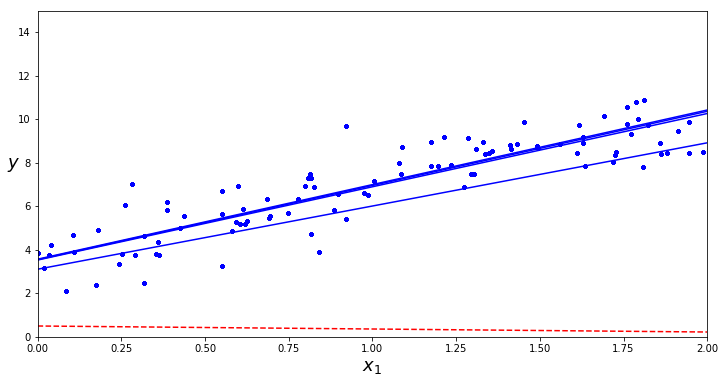

In [19]:
t0, t1 = 10, 1000  # learning schedule hyperparameters
def learningSchedule(t):
    return t0 / (t + t1)
t = 0
plt.figure(figsize=(12,6))
for epoch in range(noEpochs):
    shuffledNDX = np.random.permutation(N)
    MatXshuffled = MatX[shuffledNDX]
    yShuffled = yNoise[shuffledNDX]
    for i in range(0, N, sizeMGD):
        if epoch == 0 and i < 600:
            yPredict = MatXNew.dot(weights)          
            style = "b-" if i > 0 else "r--" 
            plt.plot(XNew, yPredict, style)   
        t += 1
        xi = MatXshuffled[i:i+sizeMGD]
        yi = yShuffled[i:i+sizeMGD]
        gradients = 2 * xi.T.dot(yi - xi.dot(weights))
        learningRate = learningSchedule(epoch * N + i)
        weights = weights + learningRate * gradients
        weightPathMGD.append(weights)
        plt.plot(X, yNoise, "b.")                                
plt.xlabel("$x_1$", fontsize=18)                    
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
print('weights: %s' %weights)
plt.show()                     

[回本章目錄](#本章目錄)

### <font color='red'>1.4.5 Learning Processes of Gradient Descent Variants</font>

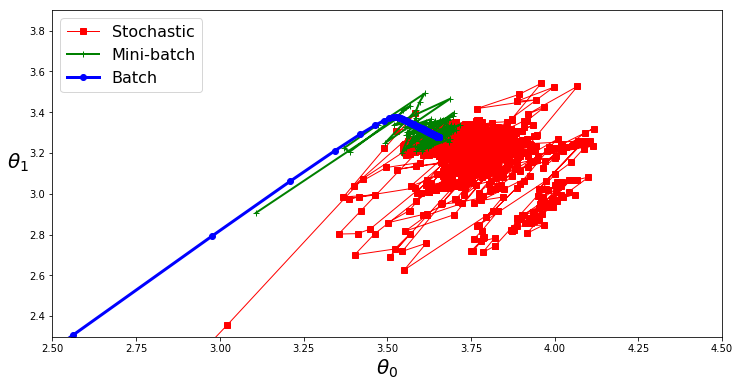

In [20]:
weightPathBGD = np.array(weightPathBGD)
weightPathSGD = np.array(weightPathSGD)
weightPathMGD = np.array(weightPathMGD)
plt.figure(figsize=(12,6))
plt.plot(weightPathSGD[:, 0], weightPathSGD[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(weightPathMGD[:, 0], weightPathMGD[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(weightPathBGD[:, 0], weightPathBGD[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

[回本章目錄](#本章目錄)

### 1. Consider that you have a training set with millions of features, will the Linear Regression training algorithm suffer from this? and how? If you have no choice but to use the Linear Regresion Model, how are you going to select Linear Regression training algorithms?

### 2. Suppose the features in your training set have very different scales. Do Linear Regression training algorithms suffer from this? and how? What can you do about it?

### Upcoming Topic: 
> ### 1. Linear Regression with TensorFlow 
> ### 2. Linear Classifiers: Logistic and Softmax Regression for Classification Tasks

[回本章目錄](#本章目錄)

## <font color='red'>1.5 Linear Regression with TensorFlow</font>

### California Housing - Descriptive Statistics (the central tendency, dispersion and shape of a  distribution, excluding NaN values)
### [California housing dataset](http://lib.stat.cmu.edu/datasets/) contains 20,640 observations on 9 variables. This dataset contains the average house value as the target variable. The followings are  input variables (features): 
### <font color='red'>*MedInc*</font> - median annual income, <font color='red'>*HouseAge*</font> - housing average age, <font color='red'>*AveRooms*</font> - average rooms, <font color='red'>*AveBedrms*</font> - average bedrooms,  <font color='red'>*Population*</font>, <font color='red'>*AveOccup*</font> - average occupation, <font color='red'>*Latitude*</font> and <font color='red'>*Longitude*</font>.
### Data Visualization Reference: [Open Data USA](https://datausa.io/profile/geo/california/#category_housing)

In [21]:
from sklearn.datasets import fetch_california_housing
housingData = fetch_california_housing()
housingDataDF = pd.DataFrame(housingData.data, columns=housingData.feature_names)
side_by_side(housingDataDF.isnull().sum(), housingDataDF.count(), 
             'Number of NAN in target variable = '+str(np.isnan(housingData.target).sum()))
housingDataDF.describe()

MedInc        0    MedInc        20640    'Number of NAN in target variable = 0'
HouseAge      0    HouseAge      20640                                          
AveRooms      0    AveRooms      20640                                          
AveBedrms     0    AveBedrms     20640                                          
Population    0    Population    20640                                          
AveOccup      0    AveOccup      20640                                          
Latitude      0    Latitude      20640                                          
Longitude     0    Longitude     20640                                          
dtype: int64       dtype: int64                                                 



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


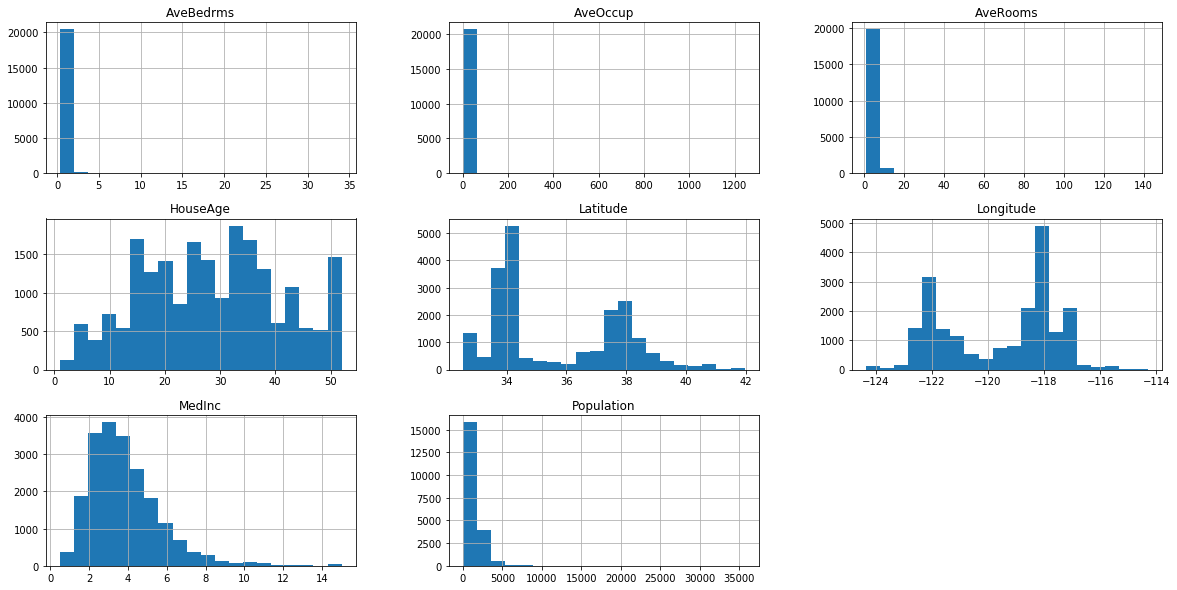

In [22]:
housingDataDF.hist(figsize=(20,10), bins=20);

In [23]:
houseValue = housingData.target
from scipy import stats
stats.describe(houseValue)

DescribeResult(nobs=20640, minmax=(0.14999, 5.00001), mean=2.068558169089147, variance=1.3316148163035277, skewness=0.9776922140978419, kurtosis=0.3275001388119616)

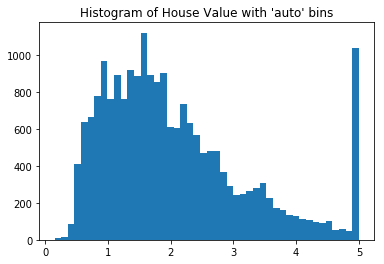

In [24]:
plt.hist(houseValue, bins='auto')
plt.title("Histogram of House Value with 'auto' bins")
plt.show()

[回本章目錄](#本章目錄)

### <font color='red'>1.5.1 Using the Normal Equation</font>

In [ ]:
import tensorflow as tf
np.random.seed(42)

In [ ]:
n, m = housingData.data.shape
housingDataBias = np.c_[np.ones((n, 1)), housingData.data]
houseValue = housingData.target.reshape(-1, 1)
side_by_side(housingData.data[:2,:2], housingDataBias[:2,:3], houseValue[:2])

In [ ]:
# construction phase
X = tf.constant(housingDataBias, dtype=tf.float32, name="X")
houseValueTF = tf.constant(houseValue, dtype=tf.float32, name="houseValue")
XT = tf.transpose(X)
# pseudo inverse matrix
weights = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), houseValueTF)

init = tf.global_variables_initializer() # pepare an init node

# execution phase
with tf.Session() as sess:
    init.run()
    weightValues = weights.eval()
# sess.close() # The session 'sess' is automatically closed at the end of the block.

weightsByNumpy = np.linalg.inv(housingDataBias.T.dot(housingDataBias)).dot(housingDataBias.T).dot(houseValue)

from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(housingData.data, houseValue)
print('Three Approaches: TensorFlow Approach, Numpy Approach and Scikit-Learn Approach\n')
side_by_side(weightValues, weightsByNumpy, np.r_[linReg.intercept_.reshape(-1, 1), linReg.coef_.T])

### <font color='red'>The main benefit of using TensorFlow is that it will automatically run this on our GPU card if we have one.</font>
###  Installed TensorFlow with GPU support via *pip3 install --upgrade tensorflow-gpu*

[回本章目錄](#本章目錄)

### <font color='red'>1.5.2 Using Batch Gradient Descent</font>

### 1. Normalizing the Feature Vectors

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaledHousingData = scaler.fit_transform(housingData.data)
scaledHousingDataBias = np.c_[np.ones((n, 1)), scaledHousingData]
side_by_side(scaledHousingDataBias.mean(axis=0).reshape(-1,1), scaledHousingDataBias.std(axis=0).reshape(-1,1))

In [ ]:
def gradientDescentBatch(gradientModel, scaledHousingDataBias, houseValue, nEpochs=1000, learningRate=0.01, momentum=0.9):
    # construction phase
    X = tf.constant(scaledHousingDataBias, dtype=tf.float32, name="X")
    houseValueTF = tf.constant(houseValue, dtype=tf.float32, name="houseValueTF")
    weights = tf.Variable(tf.random_uniform([scaledHousingDataBias.shape[1], 1], -1.0, 1.0, seed=42), name="weights")
    houseValuePred = tf.matmul(X, weights, name="predictions")
    error = houseValuePred - houseValueTF
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
    if (gradientModel == 'autodiff'):
        gradients = tf.gradients(mse, [weights])[0]
        trainingOperation = tf.assign(weights, weights - learningRate * gradients)
    elif (gradientModel == 'optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        trainingOperation = optimizer.minimize(mse)
    elif (gradientModel == 'momentum'):
        optimizer = tf.train.MomentumOptimizer(learning_rate=learningRate, momentum=0.9)
        trainingOperation = optimizer.minimize(mse)
    init = tf.global_variables_initializer()
    
    with tf.Session() as GD_Session:
        GD_Session.run(init)
        for epoch in range(nEpochs):
            if epoch % 100 == 0:
                print("..........Epoch:%s......MSE =%s" %(epoch, mse.eval()))
            GD_Session.run(trainingOperation)
        bestWeights = weights.eval()
    return bestWeights

In [ ]:
weightAutodiff = gradientDescentBatch('autodiff', scaledHousingDataBias, houseValue)
weightOptimizer = gradientDescentBatch('optimizer', scaledHousingDataBias, houseValue)
weightMomentum = gradientDescentBatch('momentum', scaledHousingDataBias, houseValue)

In [ ]:
side_by_side(weightAutodiff, weightOptimizer, weightMomentum)

[回本章目錄](#本章目錄)

### <font color='red'>1.5.3 Using Mini-Batch Gradient Descent</font>

In [ ]:
def gradientDescentMiniBatch(gradientModel, scaledHousingDataBias, houseValue, batchSize=100,
                             nEpochs=10, learningRate=0.01):
    # First change the definition of X and houseValueTF in the construction phase  to make them placeholder nodes
    
    # Constution Phase
    X = tf.placeholder(tf.float32, shape=(None, scaledHousingDataBias.shape[1]), name="X") 
    houseValueTF = tf.placeholder(tf.float32, shape=(None, 1), name="houseValueTF")
    weights = tf.Variable(tf.random_uniform([scaledHousingDataBias.shape[1], 1], -1.0, 1.0, seed=42), name="weights")
    houseValuePred = tf.matmul(X, weights, name="predictions")
    error = houseValuePred - houseValueTF
    mse = tf.reduce_mean(tf.square(error), name="mse")
    if (gradientModel == 'autodiff'):
        gradients = tf.gradients(mse, [weights])[0]
        trainingOperation = tf.assign(weights, weights - learningRate * gradients)
    elif (gradientModel == 'optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        trainingOperation = optimizer.minimize(mse)
    elif (gradientModel == 'momentum'):
        optimizer = tf.train.MomentumOptimizer(learning_rate=learningRate, momentum=0.9)
        trainingOperation = optimizer.minimize(mse)
    
    # Execution Phase
    init = tf.global_variables_initializer()
    # compute the total number of batches
    nBatches = int(np.ceil(scaledHousingDataBias.shape[0] / batchSize)) 
    with tf.Session() as GD_Session:
        GD_Session.run(init)
        for epoch in range(nEpochs):
            for batchIndex in range(nBatches):
                # np.random.seed(epoch * nBatches + batchIndex)
                indices = np.random.randint(scaledHousingDataBias.shape[0], size=batchSize)
                XBatch = scaledHousingDataBias[indices]
                houseValueBatch = houseValue[indices]
                GD_Session.run(trainingOperation, feed_dict={X:XBatch, houseValueTF:houseValueBatch})
            print("..........Epoch:%s......MSE =%s" %(epoch, mse.eval(feed_dict={X:XBatch, 
                                                                                         houseValueTF:houseValueBatch}
                                                                             )
                                                             )
                         )
        bestWeights = weights.eval()
    return bestWeights

In [ ]:
weightAutodiffMiniBatch = gradientDescentMiniBatch('autodiff', scaledHousingDataBias, houseValue)

In [ ]:
weightOptimizerMiniBatch = gradientDescentMiniBatch('optimizer', scaledHousingDataBias, houseValue)

In [ ]:
weightomentumMiniBatch = gradientDescentMiniBatch('momentum', scaledHousingDataBias, houseValue)

In [ ]:
side_by_side(weightAutodiffMiniBatch, weightOptimizerMiniBatch, weightMomentumMiniBatch)

[回本章目錄](#本章目錄)

# 2. Types of Regression
## 2.1 Polynomial Regression
## A quadratic equation is of the form $y = $ $w_{2}X^{2}$ +  $w_{1}X$ + $w_{0}$

In [ ]:
np.random.seed(42)

In [ ]:
n = 100
X = 6 * np.random.rand(n, 1) - 3
polyY = 0.5 * X**2 + X + 2 + np.random.randn(n, 1)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(X, polyY, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
polyFeatures = PolynomialFeatures(degree=2, include_bias=False) # square of polyX
polyX = polyFeatures.fit_transform(X)
side_by_side(X[0:3], polyX[0:3])

In [ ]:
linReg = LinearRegression()
linReg.fit(polyX, polyY)
side_by_side(linReg.intercept_, linReg.coef_)

In [ ]:
plt.figure(figsize=(12,6))
newX=np.linspace(-3, 3, 100).reshape(100, 1)
newPloyX = polyFeatures.transform(newX)
newPolyY = linReg.predict(newPloyX)
plt.plot(X, polyY, "b.")
plt.plot(newX, newPolyY, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

[回本章目錄](#本章目錄)

## 2.2 High-degree Polynomial Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
plt.figure(figsize=(12,6))

for style, width, degree in (("g-", 1, 99), ("b--", 2, 2), ("r-+", 2, 1)):
    polyFeatures = PolynomialFeatures(degree=degree, include_bias=False)
    stdScaler = StandardScaler()
    linReg = LinearRegression()
    polynomialRegression = Pipeline((
            ("poly features", polyFeatures),
            ("std scaler", stdScaler),
            ("lin reg", linReg),
        ))
    polynomialRegression.fit(X, polyY)
    newPolyY = polynomialRegression.predict(newX)
    plt.plot(newX, newPolyY, style, label=str(degree+1)+' DoF', linewidth=width)

plt.plot(X, polyY, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

## Q: How can you tell that your model is overfitting or underfitting the data?
> ### Answer:  
>> ### 1. Using the cross-validation to get an estimate of a model’s generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting.
>> ### 2. Visualizing it by plotting Learning Curves

[回本章目錄](#本章目錄)

## 2.3 Learning Curve
> ## A plot of the generalization performance against the amount of training data is called a learning curve

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def plotLearningCurves(model, X, y):
    plt.figure(figsize=(12,6))
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation")
    plt.legend(loc="upper right", fontsize=14)  
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14) 


In [ ]:
linReg = LinearRegression()
plotLearningCurves(linReg, X, polyY)
plt.axis([0, 80, 0, 3]) 
plt.title('Learning Curve for the Regression Model')
plt.show()   

In [ ]:
from sklearn.pipeline import Pipeline

polynomialRegression = Pipeline((
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ))

plotLearningCurves(polynomialRegression, X, polyY)
plt.title('Learning Curve for the Polynomial Model')
plt.axis([0, 80, 0, 3])           
plt.show()                        

[回本章目錄](#本章目錄)

## 2.4 Model Complexity Generalization Error - The Bias-Variance Tradeoff

### If we denote the variable we are trying to predict as $y$ and our covariates as $X$, we may assume that there is a relationship relating one to the other such as $ y = f(X) + \epsilon $ where the error term $ \epsilon $ is normally distributed with a mean of zero, i.e. $ \epsilon \sim \mathcal{N}(0,\sigma_\epsilon) $
# 
### We may estimate a model $ \hat{f}(X)$ $\equiv \hat{y}$ of $ f(X) $ using linear regressions or another modeling technique. In this case, the expected squared prediction error at a point $ x $ is:
> ### $$ Error(x) = E\left[(y-\hat{f}(x))^2\right] = E\left[(y-\hat{y})^2\right]$$
## This error may then be decomposed into bias and variance components

![](./Data_and_Images/Chapter_6/Model_Complexity.png)

## Bias <font color='red'>$(y-E[\hat{y}])^{2}$</font>
> ### This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.
 
## Variance <font color='red'>$Var[\hat{y}]$</font>
> ### This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

## Tradeoff
> ### Increasing a model’s complexity will typically increase its variance and reduce its bias. On the other hand, reducing a model’s complexity increases its bias and reduces its variance.

## Irreducible error due to the noisiness of the data <font color='red'>$Var[{y}]$</font>
> ### The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

# <center> Bias–Variance Decomposition for Squared Error </center>
## <center> $E[{y-\hat{y}}]^{2}$ =  $ Bais[\hat{y}]$ + $ Var[\hat{y}]$ +  $\sigma^{2}$ </center>
## <center><font color='red'> Q: Derivation of the above Bias–Variance decomposition for squared errorequation.</font></center>
## $$Error(x) = \left(E[y-\hat{y}])\right)^2 + E\left[\left(\hat{y}-E[\hat{y}]\right)^2\right] +\sigma_e^2 $$

# Main Challenges of Learning

> ## 1. Insufficient Quantity of Training Data, 2. Nonrepresentative Training Data, 3. Poor-Quality Data, 4. Irrelevant Features, 5. Overfitting the Training Data, 6. Underfitting the Training Data

## <font color='red'> Q: If your model performs great on the training data but generalizes poorly to new instances, what is happening? Can you name three possible solutions?</font>

[回本章目錄](#本章目錄)

## 2.5 Regularized Linear Model - Ridge Regression
### A good way to reduce overfitting is to regularize the model (i.e., to constrain it). For Example, a simple way to regularize a polynomial model is to reduce the number of polynomial degrees.
### Ridge Regression Cost Function
### $$ J(w) = MSE(w) + \alpha\frac{1}{2} \sum_{i=1}^{n} w_i^2$$
### The regularization term  $\alpha\frac{1}{2} \sum_{i=1}^{n} w_i^2$is added to the cost function which forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to evaluate the model’s performance using the unregularized performance measure.

### Most regularized models are sensitive to the scale of the input features, we need to <font color='red'>scale(standardization)</font> the data.

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
np.random.seed(42)
n = 20
X = 3 * np.random.rand(n, 1)
ridgeY = 1 + 0.5 * X + np.random.randn(n, 1) / 1.5
newX = np.linspace(0, 3, 100).reshape(100, 1)

def plotModel(modelClass, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = modelClass(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline((
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ))
        model.fit(X, ridgeY)
        y_new_regul = model.predict(newX)
        lw = 2 if alpha > 0 else 1
        plt.plot(newX, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, ridgeY, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title('Polynomial = False')
plotModel(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plt.title('Polynomial = True')
plotModel(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

[回本章目錄](#本章目錄)